In [ ]:
# default_exp seg_unet_training

In [ ]:
#export
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from ocr.seg_dataset_isri_unlv import isri_unlv_config
from pathlib import PosixPath

In [ ]:
from ocr.core import save_inference, load_inference

In [ ]:
#export
codes = list(isri_unlv_config.cat2id.keys())

In [ ]:
print(codes)

['Background', 'Attent_line', 'Other_Text', 'cc', 'Company_Sig', 'Subject', 'Enclosure', 'Sign/Type', 'Inside_Addr', 'Dateline', 'Footnote', 'Closing', 'Salutat', 'Signer', 'Letterhead', 'Table', 'Caption', 'Header/Footer', 'Text']


In [ ]:
path_lbl = isri_unlv_config.SEG_DIR
path_img = isri_unlv_config.IMG_DIR

In [ ]:
a = os.listdir(path_lbl)
b = os.listdir(path_img)

In [ ]:
for x in b:
    if x not in a:
        print(x)

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('../data/seg/images/isri_unlv_574.png'),
 PosixPath('../data/seg/images/isri_unlv_3056.png'),
 PosixPath('../data/seg/images/isri_unlv_9089.png')]

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('../data/seg/labels/isri_unlv_574.png'),
 PosixPath('../data/seg/labels/isri_unlv_3056.png'),
 PosixPath('../data/seg/labels/isri_unlv_9089.png')]

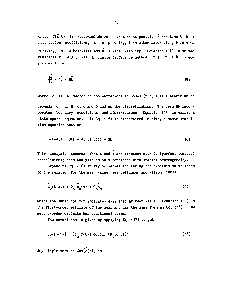

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

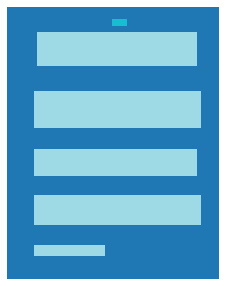

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data.unique()

(array([2200, 1712]), tensor([ 0, 17, 18]))

In [ ]:
# w = 360
w = 480
size = np.array([int(w*1.3), w])
bs = 4

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.1)
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
#export
train_transforms = [
#     crop_pad(),
    rotate(degrees=(-10, 10), p=0.9),
    symmetric_warp(magnitude=(-0.1, 0.1), p=0.9),
#     dihedral_affine(p=1), # (flips image), will cause problems, because top left corner will be for example bottom right
#     rand_zoom(scale=(.5,1.), p=0.9),
    brightness(change=(0.4, 0.6), p=0.8),
    contrast(scale=(0.8,1.2), p=0.8),
]

valid_transforms = [
    rotate(degrees=(-1, 1), p=0.2)
]
transforms = (train_transforms, valid_transforms)
# transforms = get_transforms()

In [ ]:
data = (src.transform(transforms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (8181 items)
x: SegmentationItemList
Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480)
y: SegmentationLabelList
ImageSegment (1, 624, 480),ImageSegment (1, 624, 480),ImageSegment (1, 624, 480),ImageSegment (1, 624, 480),ImageSegment (1, 624, 480)
Path: ../data/seg/images;

Valid: LabelList (909 items)
x: SegmentationItemList
Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480)
y: SegmentationLabelList
ImageSegment (1, 624, 480),ImageSegment (1, 624, 480),ImageSegment (1, 624, 480),ImageSegment (1, 624, 480),ImageSegment (1, 624, 480)
Path: ../data/seg/images;

Test: None

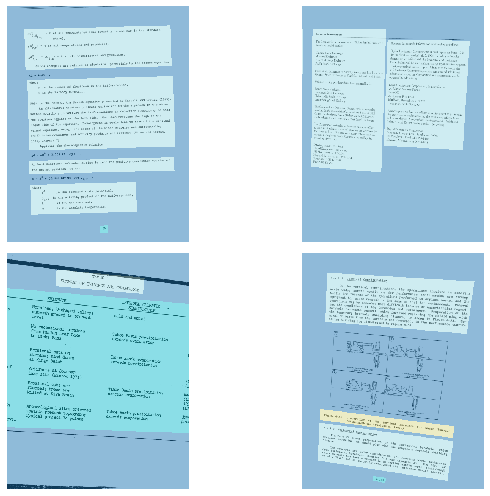

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
#export
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.path = PosixPath('.')
learn.callbacks.append(ShowGraph(learn))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


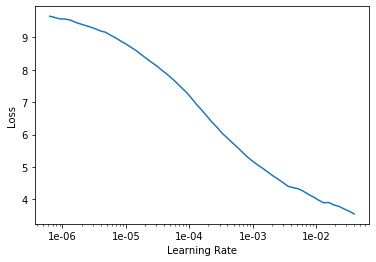

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4

epoch,train_loss,valid_loss,acc_camvid,time
0,0.448622,0.386501,0.793292,12:42
1,0.330514,0.322868,0.809055,12:42
2,0.262701,0.234014,0.873879,12:41
3,0.228831,0.209742,0.883926,12:42
4,0.201438,0.203762,0.898781,12:42


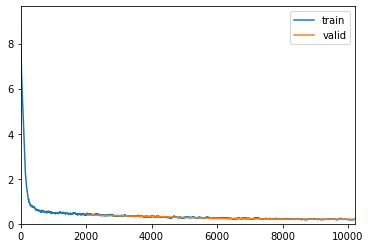

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
save_inference(learn, 'unet_layout')

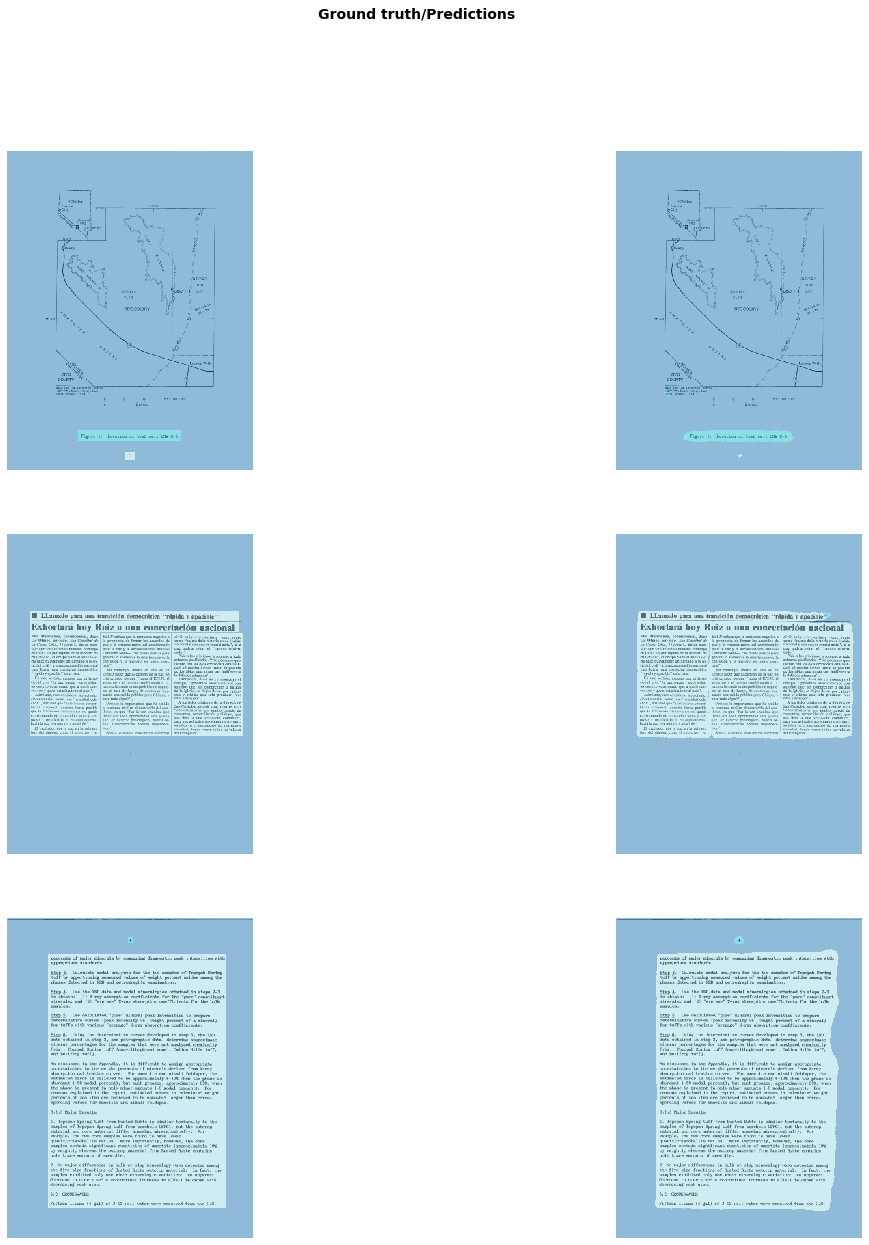

In [ ]:
learn.show_results(rows=3, figsize=(20,20))

In [ ]:
learn = load_inference('unet_layout')
learn.data = data

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.188230,0.208030,0.887417,13:22
1,0.199101,0.187736,0.909444,13:22
2,0.153821,0.184255,0.911357,13:24
3,0.171491,0.168419,0.915544,13:23
4,0.138963,0.176953,0.913312,13:24


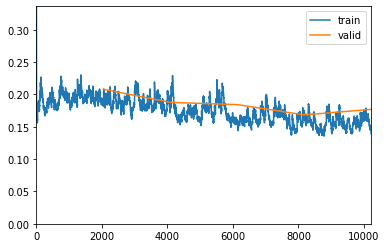

In [ ]:
learn.fit_one_cycle(5, slice(lr/50, lr/10))

In [ ]:
save_inference(learn, 'unet_layout')

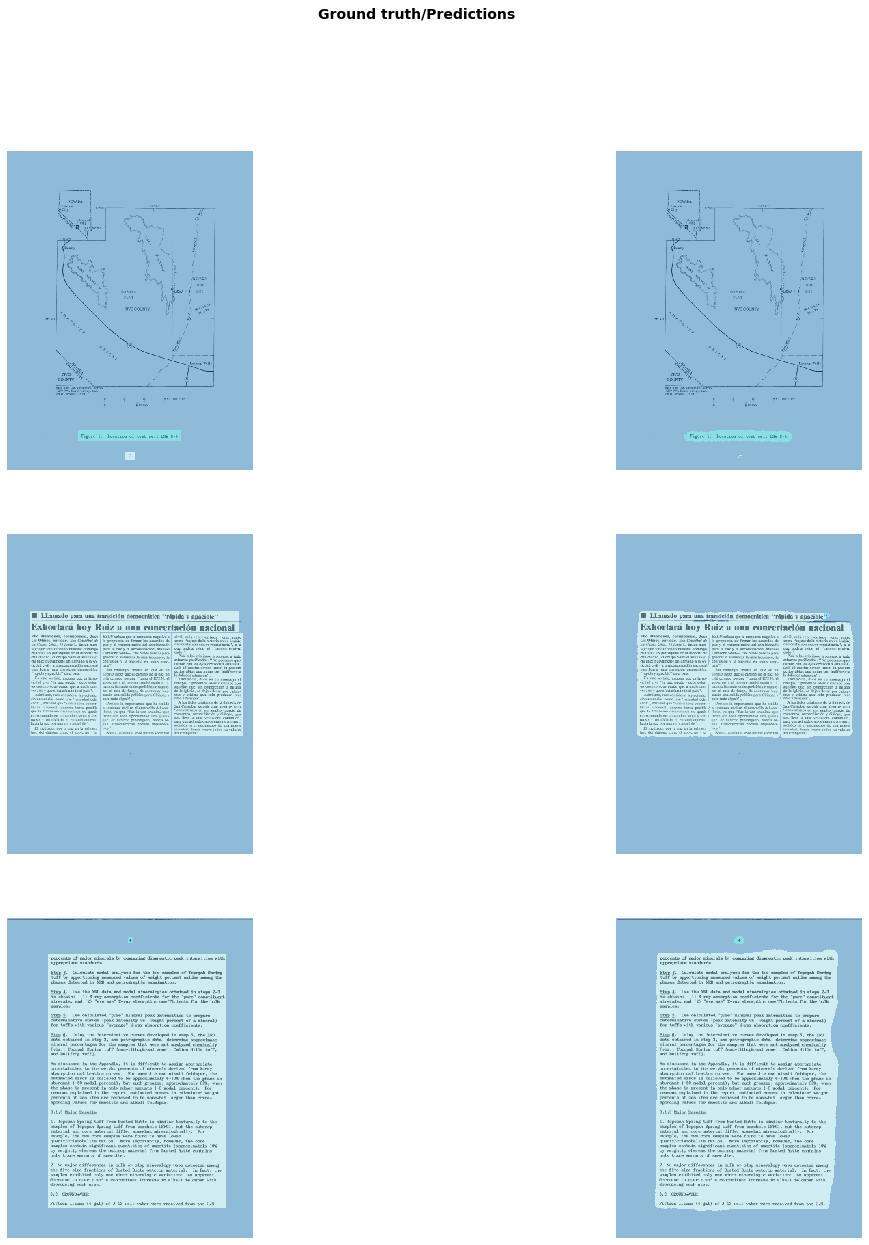

In [ ]:
learn.show_results(rows=3, figsize=(20,20))

In [ ]:
learn.fit_one_cycle(30, 1e-5)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.148212,0.116106,0.939717,21:59
1,0.117813,0.104707,0.943129,21:58
2,0.109622,0.099199,0.947282,21:59
3,0.098514,0.096525,0.953060,21:59
4,0.099808,0.091160,0.951540,21:59
5,0.097284,0.100264,0.956360,21:58
6,0.092126,0.088490,0.949456,21:58
7,0.082255,0.088073,0.959146,21:59
8,0.090671,0.087268,0.958905,21:59
9,0.081596,0.083450,0.957528,21:58


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch,train_loss,valid_loss,acc_camvid,time
0,0.046851,0.075455,0.971260,21:52


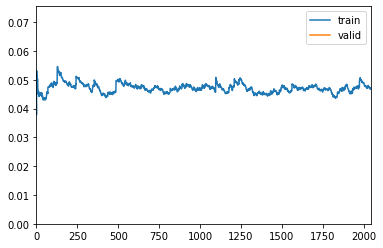

In [ ]:
learn.fit_one_cycle(1, 1e-6)

In [ ]:
save_inference(learn, 'unet_layout')

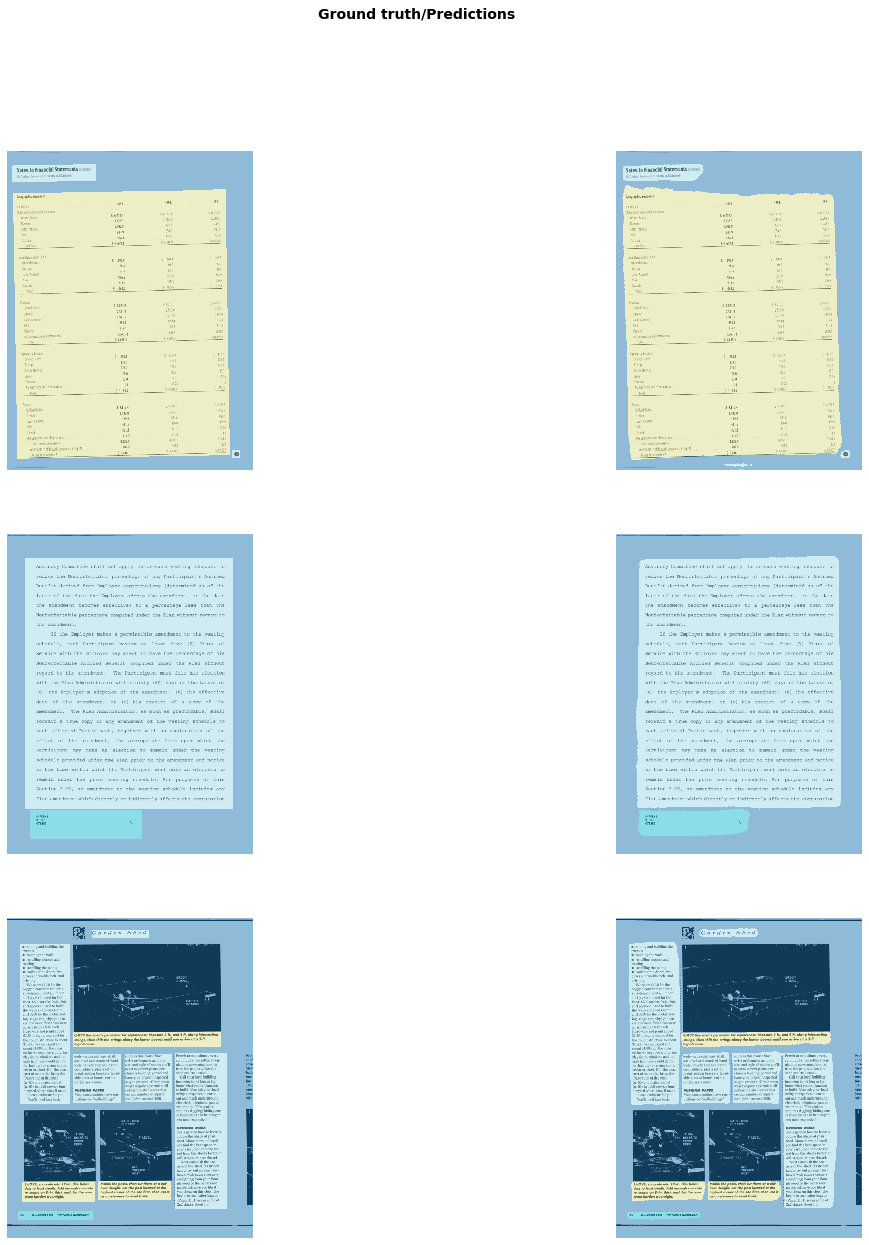

In [ ]:
learn.show_results(rows=3, figsize=(20,20))